# Random Number Decomposition
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$


Tutorials:
* see [Turing.jl Introduction](https://turinglang.org/docs/tutorials/docs-12-using-turing-guide/index.html) for the basic functions.
* See [Multinomial Logistic Regression](https://turinglang.org/docs/tutorials/08-multinomial-logistic-regression/) for more info about inference
* [Performance Optimization](https://turing.ml/v0.22/docs/using-turing/performancetips#choose-your-ad-backend)

In [1]:
using Pkg
Pkg.activate(".")
#Pkg.add("MCMCChains")
#Pkg.add("StatsPlots")
#Pkg.add("FillArrays")
#Pkg.add("Turing")

  Activating project at `d:\Code\ProbabilisticProgramming`


In [2]:
using Turing, Distributions, Statistics, Distributed, Test
# Functionality for constructing arrays with identical elements efficiently.
using FillArrays
# Functionality for working with scaled identity matrices.
using LinearAlgebra
# Load StatsPlots for visualizations and diagnostics.
using StatsPlots # -> plot(chain)
using MCMCChains


In [19]:
cc_12 = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (-1, 1),
        2 => (1, 1),
        ),
]
cct = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (10, 1),
        2 => (-10, 1),
        ),
]
cc_14 = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (1, 1),
        2 => (2, 1),
        3 => (3, 2),
        4 => (4, 1)
        ),
]
cc_14s = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (1, 1),
        2 => (2, 1),
        3 => (3, 1),
        4 => (4, 1)
        ),
]
cc_1x = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (0, 1),
        2 => (0, 1),
        3 => (2, 2),
        4 => (0, 1)
        ),
]
cc_29 = [
    Dict( 1 => (0, 5)),
    Dict( 
        1 => (1, 1),
        2 => (2, 1),
        3 => (3, 2),
        4 => (4, 1)
        ),
    Dict( 
        1 => (1, 1),
        2 => (2, 1),
        3 => (3, 2),
        4 => (4, 1),
        5 => (5, 1)
        ),
]

3-element Vector{Dict{Int64, Tuple{Int64, Int64}}}:
 Dict(1 => (0, 5))
 Dict(4 => (4, 1), 2 => (2, 1), 3 => (3, 2), 1 => (1, 1))
 Dict(5 => (5, 1), 4 => (4, 1), 2 => (2, 1), 3 => (3, 2), 1 => (1, 1))

In [4]:
"""align coefficients to have a mean of 0 for every layer"""
function align_coefficients(coefficients)
    @assert (length(coefficients[1]) == 1) "first level is just allowed to have one contributer"
    coefs2 = []
    for layer in coefficients
        means = [m for (k, (m, v)) in layer]
        m0 = mean(means)
        # adjust the means
        append!(coefs2, [Dict(k=> (m - m0, v) for (k, (m, v)) in layer)]) #every element from the list will be added => [Dict()]
    end
    coefs2
end
@test_throws AssertionError begin
    cc = [ Dict( 1 => (0, 5), 2 => (3, 4))]
    align_coefficients(cc)
end
@test begin
    cc = [
    Dict( 1 => (2, 5)),
    Dict( 
        1 => (1, 1),
        2 => (2, 1),
        3 => (3, 2),
        ),
]
    align_coefficients(cc) == [Dict(1 => (0.0, 5))
    Dict(2 => (0.0, 1), 3 => (1.0, 2), 1 => (-1.0, 1))]
end

"""create random numbers out of a set of coefficients"""
function generate_data(coefficients, n_samples)
    @assert n_samples > 0
    coefficients = align_coefficients(coefficients)
    data = Vector{Float16}(undef, n_samples)
    data .= 0

    contributers = []
    for layer in coefficients
        max_con = maximum(collect(keys(layer)))
        cons = rand(1:max_con, n_samples)
        for (con, (mu, sigma)) in layer
            rows = cons.== con
            n_rows = sum(rows)
            N = Normal(mu, sigma)
            data[rows] += rand(N, n_rows)
        end
        append!(contributers, [cons])

    end
    popfirst!(contributers) # first set has by default just one contributer
    data, contributers
end

generate_data

In [25]:
@model function model_fun3(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    μ_cons = Vector{Float16}(undef, n_contributers)

    cons = Vector{Float16}(undef, n_contributers)

    for i in 1:(n_contributers-1)
        μ_cons[i] ~ Uniform(0, max_con)
        cons[i] ~ Normal(μ_cons[i], sigmax)
    end
    μ_cons[n_contributers] ~ Uniform(0, max_con)
    cons[n_contributers] ~ Normal(-sum(μ_cons[1:(n_contributers-1)]), sigmax) #normalization
    

    for con = 1:n_contributers
        rows = contributers .== con
        data[rows] .~ Normal(μ_a + cons[con], sigma)
    end
end # Works :-D

@model function model_fun4(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    μ_cons = Vector{Float16}(undef, n_contributers)

    cons = Vector{Float16}(undef, n_contributers)

    for i in 1:(n_contributers-1)
        μ_cons[i] ~ Uniform(0, max_con)
        cons[i] ~ Normal(μ_cons[i], sigmax)
    end
    μ_cons[n_contributers] ~ Uniform(0, max_con)
    cons[n_contributers] ~ Normal(-sum(μ_cons[1:(n_contributers-1)]), sigmax) #normalization
    
    m = Vector{Float16}(undef, length(data))
    m .= μ_a

    for con = 1:n_contributers
        rows = contributers .== con
        m[rows] .+= cons[con]
        #data[rows] .~ Normal(μ_a + cons[con], sigma)
    end
    for i=1:length(data)
        data[i] ~ Normal(m[i], sigma)
    end
end # DOES NOT WORK

@model function model_fun5(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    μ_cons = Vector{Float16}(undef, n_contributers)

    cons = Vector{Float16}(undef, n_contributers)

    for i in 1:(n_contributers-1)
        μ_cons[i] ~ Uniform(0, max_con)
        cons[i] ~ Normal(μ_cons[i], sigmax)
    end
    μ_cons[n_contributers] ~ Uniform(0, max_con)
    cons[n_contributers] ~ Normal(-sum(μ_cons[1:(n_contributers-1)]), sigmax) #normalization

    for i in eachindex(data)
        data[i] ~ Normal(μ_a + cons[contributers[i]], sigma)
    end
end #works

@model function model_fun6(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    cons = Vector{Float16}(undef, n_contributers)

    for i in eachindex(cons)
        cons[i] ~ Normal(0, sigmax)
    end

    for i in eachindex(data)
        data[i] ~ Normal(μ_a + cons[contributers[i]], sigma)
    end
end #works

@model function model_fun7(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    μ_cons = Vector{Float16}(undef, n_contributers)
    σ_cons = Vector{Float16}(undef, n_contributers)

    cons = Vector{Float16}(undef, n_contributers)

    for i in 1:(n_contributers-1)
        μ_cons[i] ~ Uniform(0, max_con)
        σ_cons[i] ~ Uniform(0, sigmax)
        cons[i] ~ Normal(μ_cons[i], σ_cons[i] )
    end
    μ_cons[n_contributers] ~ Uniform(0, max_con)
    σ_cons[n_contributers] ~ Uniform(0, sigmax)
    cons[n_contributers] ~ Normal(-sum(μ_cons[1:(n_contributers-1)]), σ_cons[n_contributers]) #normalization

    for i in eachindex(data)
        data[i] ~ Normal(μ_a + cons[contributers[i]], sigma)
    end
end #works

@model function model_fun8(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)

    cons ~MvNormal(Zeros(n_contributers-1), Ones(n_contributers-1))

    μ_a ~ Normal( -10, 10) 
    sigma ~ Uniform(0, sigmax)

    for i in eachindex(data)
        if contributers[i] == n_contributers
            data[i] ~ Normal(μ_a + -sum(cons), sigma)
        else
            data[i] ~ Normal(μ_a + cons[contributers[i]], sigma)
        end
    end
end

@model function model_fun9(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)

    cons ~MvNormal(Zeros(n_contributers), Ones(n_contributers))

    μ_a ~ Normal( -10, 10) 
    sigma ~ Uniform(0, sigmax)

    for i in eachindex(data)
        data[i] ~ Normal(μ_a + cons[contributers[i]], sigma)
    end
end

@model function model_fun10(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)

    cons ~MvNormal(Zeros(n_contributers), Ones(n_contributers))

    μ_a ~ Normal( -10, 10) 
    sigma ~ Uniform(0, sigmax)

    get_cons(i) = cons[i] #function to define broadcasting

    data .~ MvNormal(μ_a .+ get_cons.(contributers), sigma)
end

@model function model_fun10(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)

    cons ~MvNormal(Zeros(n_contributers), Ones(n_contributers))

    μ_a ~ Normal( -10, 10) 
    sigma ~ Uniform(0, sigmax)

    get_cons(i) = cons[i] #function to define broadcasting

    data .~ MvNormal(μ_a .+ get_cons.(contributers), sigma)
end

@model function model_fun11(data, contributers)
    n_contributers = maximum(contributers)
    sigmax = var(data)
    max_con = 5 #Maximum expected value for contributers
    μ_a ~ Normal( 0, 10) 
    sigma ~ Uniform(0, sigmax)

    μ_cons = Vector{Float16}(undef, n_contributers)

    σ_cons ~ MvNormal(Zeros(n_contributers), Ones(n_contributers))

    μ_cons[1:(n_contributers-1)] ~ MvNormal(Zeros(n_contributers-1), max_con.*Ones(n_contributers-1))
    cons[1:(n_contributers-1)] ~ MvNormal(μ_cons, σ_cons)
    cons[n_contributers] ~ Normal(-sum(μ_cons[1:(n_contributers-1)]), σ_cons[n_contributers]) #normalization

    get_cons(i) = cons[i] #function to define broadcasting

    data .~ MvNormal(μ_a .+ get_cons.(contributers), sigma)
end #works

model_fun11 (generic function with 2 methods)

In [12]:
function run_chain(coefficients, model_fun, iterations, samples)
    @assert samples < 2000 #works for 2000, breaks for 10000
    data, contributers = generate_data(coefficients, samples)
    model = model_fun(data, contributers[1])
    chain = sample(model, NUTS(), iterations)
    println(align_coefficients(coefficients))
    chain
end

run_chain (generic function with 1 method)

# Solver
* Which solver to use? --> see [demo](https://turing.ml/docs/sampler-viz/)
* [Performance tips](https://turing.ml/v0.22/docs/using-turing/performancetips)

In [26]:
chain = run_chain(cc_14s, model_fun11, 5000, 1999)
fig = plot(chain)
summarystats(chain)
quantile(chain)

UndefVarError: UndefVarError: `cons` not defined

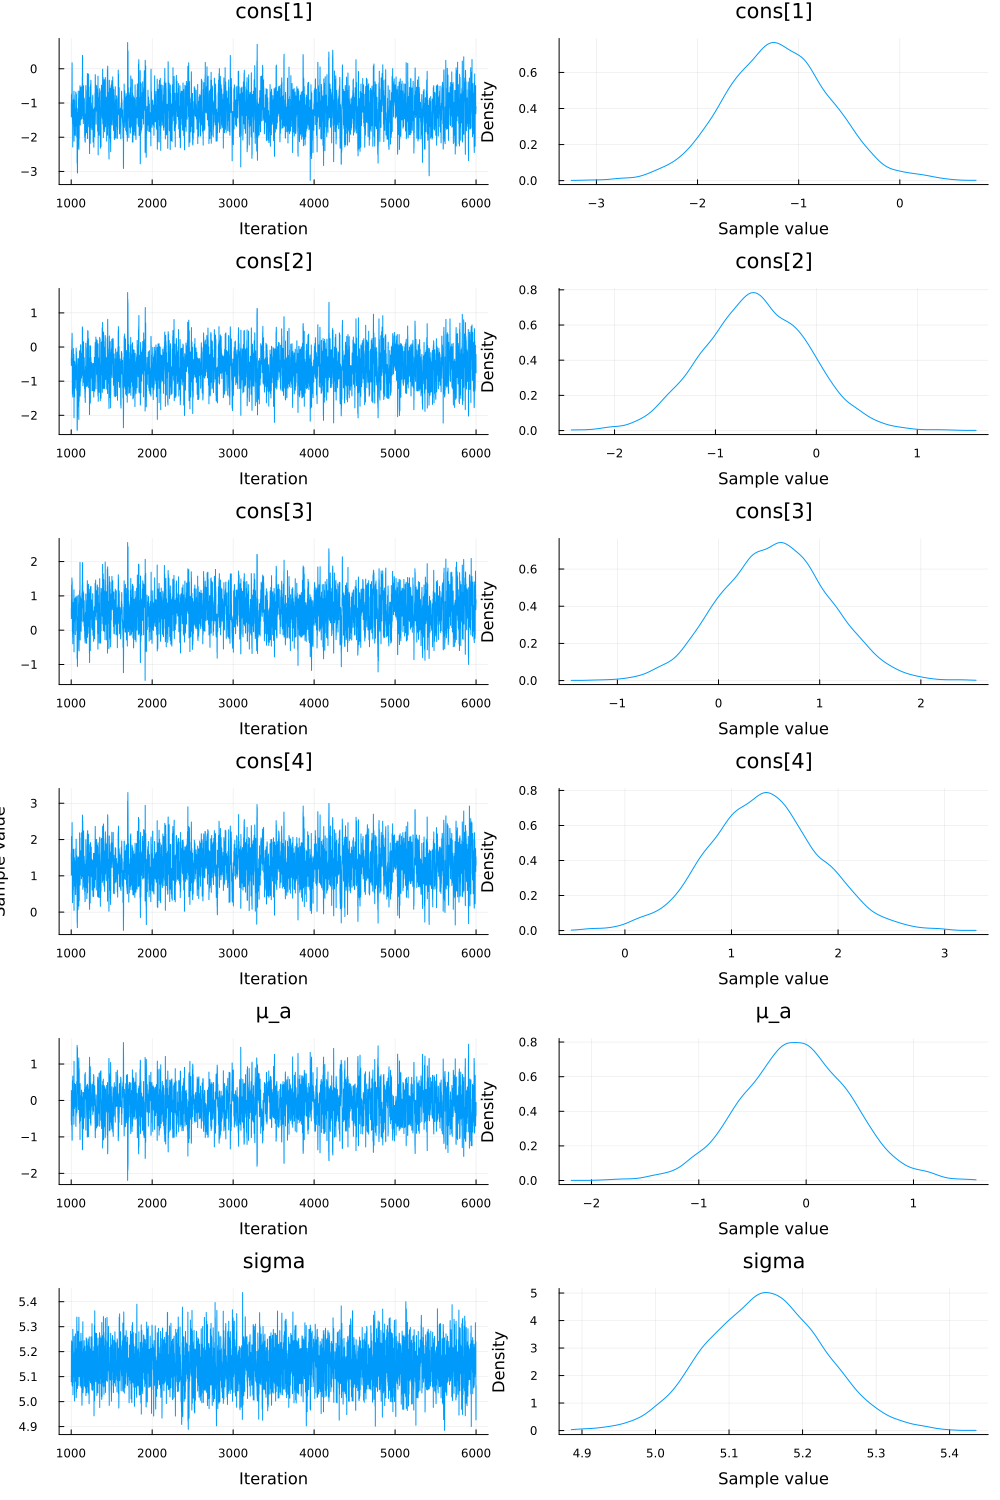

In [22]:
plot(chain)

# Reliability diagnostics
[Convergence and efficiency diagnostics for Markov Chains](https://mc-stan.org/rstan/reference/Rhat.html)

* rhat should be less than 1.05
* ESS should both by larger than 100

More docs on Monte [Carlo Simulations](https://bookdown.org/compfinezbook/introcompfinr/Using-Monte-Carlo-Simulation.html)

Handling Chains, see [MCMCChains.jl](https://turinglang.org/MCMCChains.jl/dev/chains/)

In [8]:
chain

Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 9.77 seconds
Compute duration  = 9.77 seconds
parameters        = cons[1], cons[2], cons[3], cons[4], μ_a, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

     cons[1]   -1.1404    0.5602    0.0359   243.9390   380.5669    1.0023     ⋯
     cons[2]   -0.5897    0.5618    0.0364   235.2231   457.2884    1.0001     ⋯
     cons[3]    0.4780    0.5619    0.0366   233.4821   415.8226    1.0031     ⋯
     cons[4]    1.1477    0.5787    0.0381   227.8132   444.7066    1.0003     ⋯
         μ_a    0.0471    0.

In [16]:
quantile(chain)

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     cons[1]   -2.2011   -1.5281   -1.1431   -0.7700   -0.0475
     cons[2]   -1.6634   -0.9760   -0.6126   -0.1988    0.5857
     cons[3]   -0.6141    0.1009    0.4586    0.8531    1.5531
     cons[4]    0.0222    0.7484    1.1332    1.5391    2.3730
         μ_a   -1.0065   -0.3193    0.0569    0.4050    1.0940
       sigma    4.8410    4.9731    5.0515    5.1262    5.2727


In [14]:
summarystats(chain)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

     cons[1]   -1.1404    0.5602    0.0359   243.9390   380.5669    1.0023     ⋯
     cons[2]   -0.5897    0.5618    0.0364   235.2231   457.2884    1.0001     ⋯
     cons[3]    0.4780    0.5619    0.0366   233.4821   415.8226    1.0031     ⋯
     cons[4]    1.1477    0.5787    0.0381   227.8132   444.7066    1.0003     ⋯
         μ_a    0.0471    0.5280    0.0368   206.8147   392.8062    1.0011     ⋯
       sigma    5.0520    0.1144    0.0046   615.3092   599.6674    0.9999     ⋯
                                                                1 column omitted


In [18]:
# Highest posterior density ((1-α)-interval)
hpd(chain)

HPD
  parameters     lower     upper 
      Symbol   Float64   Float64 

     cons[1]   -2.1608   -0.0127
     cons[2]   -1.7378    0.4231
     cons[3]   -0.5543    1.5966
     cons[4]   -0.0534    2.1987
         μ_a   -1.1081    0.9786
       sigma    4.8408    5.2726


In [32]:
typeof(quantile(chain))

ChainDataFrame{@NamedTuple{parameters::Vector{Symbol}, 2.5%::Vector{Float64}, 25.0%::Vector{Float64}, 50.0%::Vector{Float64}, 75.0%::Vector{Float64}, 97.5%::Vector{Float64}}}

In [38]:
quantile(chain)[:sigma]

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       sigma    4.8410    4.9731    5.0515    5.1262    5.2727


In [47]:
get_params(chain)

(hamiltonian_energy = [3049.6747158316425; 3056.95419052734; … ; 3051.7243536534165; 3056.470719697495;;], n_steps = [7.0; 7.0; … ; 15.0; 3.0;;], numerical_error = [0.0; 0.0; … ; 0.0; 0.0;;], max_hamiltonian_energy_error = [-0.29379800839069503; 2.4760759289792986; … ; 1.1096175158122605; 0.5403039160528351;;], hamiltonian_energy_error = [-0.20900464529131568; 1.2949622877222282; … ; 0.42996800060927853; 0.5403039160528351;;], cons = ([-1.2547359312204711; -1.2752330177392102; … ; -1.819464733757458; -0.9481913042007561;;], [-0.19025043783710685; -0.9269136273241019; … ; -1.0752566095609877; -1.6008554484446302;;], [0.33131405205817166; 0.5050414472285695; … ; -0.22874074739569203; 0.3657645389931813;;], [1.4107908910550897; 1.1984760797779863; … ; 1.1128790311618915; -0.10286585109304044;;]), is_accept = [1.0; 1.0; … ; 1.0; 1.0;;], sigma = [5.051518756002763; 5.184437210177007; … ; 5.18112102908735; 5.10988441290194;;], log_density = [-3046.9226669271243; -3049.905212065508; … ; -3049

In [13]:
typeof(describe(chain)[2])

ChainDataFrame{@NamedTuple{parameters::Vector{Symbol}, 2.5%::Vector{Float64}, 25.0%::Vector{Float64}, 50.0%::Vector{Float64}, 75.0%::Vector{Float64}, 97.5%::Vector{Float64}}}

In [31]:
@model function model_ref(data, contributers)
    sigmax = var(data)
    μ_a ~ Normal( 0, 10)
    sigma ~ Uniform(0, sigmax)
    #=
    pb_sig ~ Uniform(0,1)
    pa_sig ~ Uniform(0,1)

    sigma = sqrt(pa_sig * sigmax)
    sigma_b = sqrt(pb_sig * sigmax * (1-pa_sig) )
    sigma_c = sqrt(sigmax - sigma - sigma_b)
    =#
    μ_b ~ Normal(0, 10)

    b ~ Normal.(μ_b, 2)
    c ~ Normal.(-μ_b, 2)
    
    m = μ_a .+ (contributers .== 1) .* b .+ (contributers .== 2) .* c

    data .~ Normal.(m, sigma)
end

model_ref (generic function with 2 methods)

In [32]:
model_12bref = model_ref(data_12, contributers_12[1])
chain_12bref = sample(model_12bref, NUTS(), 10000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\fuerf\.julia\packages\Turing\QN7BL\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 0:23:26
Sampling   1%|█                                         |  ETA: 0:12:25
Sampling   2%|█                                         |  ETA: 0:08:29
Sampling   2%|█                                         |  ETA: 0:06:31
Sampling   2%|██                                        |  ETA: 0:05:18
Sampling   3%|██                                        |  ETA: 0:04:31
Sampling   4%|██                                        |  ETA: 0:03:56
Sampling   4%|██                                        |  ETA: 0:03:30
Sampling   4%|██                                        |  ETA: 0:03:10
Sampling   5%|███                                       |  ETA: 0:02:53
Sampling   6%|███                                       |  ETA: 0:02:40
Sampling   

Chains MCMC chain (10000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 46.6 seconds
Compute duration  = 46.6 seconds
parameters        = μ_a, sigma, μ_b, b, c
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         μ_a   -0.0430    1.3930    0.0243   3306.1092   3861.4329    1.0004   ⋯
       sigma    5.0660    0.1127    0.0013   7620.6195   5132.2869    0.9999   ⋯
         μ_b   -0.4132    1.4153    0.0164   7403.0324   5638.0681    1.0005   ⋯
           b   -0.4375    1.3942    0.0242   3335.3200   3932.9684    1.0003   ⋯
           c    0.4300    1.3959    0.0242   3337